In [1]:
# =========================================================
# Step 0) Setup & Imports (Kaggle-ready)
# =========================================================

!pip -q install xgboost

import os
import sys
import math
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML / Metrics (baselines)
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    mean_absolute_error, mean_squared_error
)

# For pretty tables 
try:
    from tabulate import tabulate
except Exception:
    tabulate = None

# Plot settings
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["axes.grid"] = True
warnings.filterwarnings("ignore")

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ---------------------------------------------------------
# Helper: find your NWSS CSV under /kaggle/input automatically
# ---------------------------------------------------------
def find_csv_in_kaggle_input(name_hint="nwsssc2regionalactivitylevelDL.csv"):
    base = Path("/kaggle/input")
    if not base.exists():
        return None
    for root, _, files in os.walk(base):
        for f in files:
            if name_hint.lower() in f.lower():
                return str(Path(root) / f)
    return None

# Set this to your known path if you already created a dataset;
# otherwise we’ll try to auto-detect it.
CSV_PATH = os.environ.get("NWSS_CSV_PATH", "").strip()

if not CSV_PATH:
    detected = find_csv_in_kaggle_input("nwsssc2regionalactivitylevelDL.csv")
    if detected:
        CSV_PATH = detected
    else:
        # Fallback: if you plan to upload the file via the Kaggle "Upload" button,
        # it will typically sit one level up from the working dir:
        alt = Path("../input/nwsssc2regionalactivitylevelDL.csv")
        CSV_PATH = str(alt) if alt.exists() else ""

print("CSV_PATH =", CSV_PATH if CSV_PATH else "(not found yet)")
if not CSV_PATH:
    print("Tip: Create a Kaggle Dataset or use the sidebar Upload, then rerun Step 0.")

CSV_PATH = /kaggle/input/nwss-dataset/nwsssc2regionalactivitylevelDL.csv


In [2]:
# =========================================================
# Step 1) Load NWSS CSV (Regional) & Inspect
# =========================================================

assert CSV_PATH and os.path.exists(CSV_PATH), (
    f"CSV not found. Current CSV_PATH='{CSV_PATH}'. "
    "Fix the path in Step 0, then re-run."
)

# Load
df = pd.read_csv(CSV_PATH)

# Basic cleaning / typing
if "Week_Ending_Date" in df.columns:
    df["Week_Ending_Date"] = pd.to_datetime(df["Week_Ending_Date"], errors="coerce")

# Optional: parse/update timestamp if present
if "date_updated" in df.columns:
    # Keep as string; do not convert timezone for now (for reproducibility)
    df["date_updated"] = df["date_updated"].astype(str)

# Sort by date if available
if "Week_Ending_Date" in df.columns:
    df = df.sort_values("Week_Ending_Date")

# Drop exact duplicate rows (if any)
df = df.drop_duplicates().reset_index(drop=True)

# Quick checks
print("Wide shape:", df.shape)
print("Columns:", list(df.columns))
print("\nHead:")
display(df.head(10))

# Sanity check: ensure expected region columns exist
expected_suffix = "_WVAL"
region_cols = [c for c in df.columns if c.endswith(expected_suffix)]
if not region_cols:
    raise ValueError(
        "No region columns ending with '_WVAL' were found. "
        "Expected columns like 'Midwest_WVAL', 'Northeast_WVAL', 'South_WVAL', 'West_WVAL', 'National_WVAL'."
    )

print("\nDetected region columns:", region_cols)

# Missing-value report
mv = df[["Week_Ending_Date"] + region_cols].isna().mean().sort_values(ascending=False)
print("\nMissing-value rates (fraction of rows):")
display(mv.to_frame("missing_rate").T if mv.ndim == 1 else mv)

Wide shape: (189, 7)
Columns: ['Week_Ending_Date', 'Midwest_WVAL', 'Northeast_WVAL', 'South_WVAL', 'West_WVAL', 'National_WVAL', 'date_updated']

Head:


,Week_Ending_Date,Midwest_WVAL,Northeast_WVAL,South_WVAL,West_WVAL,National_WVAL,date_updated
0,2022-01-01,15.868228,29.382200,23.266478,12.595932,19.567353,2025-08-15T12:30:30.214Z
1,2022-01-08,19.488601,28.111731,27.170976,22.812091,24.991534,2025-08-15T12:30:30.214Z
2,2022-01-15,15.514461,20.309058,22.005980,25.659279,21.157519,2025-08-15T12:30:30.214Z
3,2022-01-22,13.462043,13.915469,17.381904,24.101298,15.648686,2025-08-15T12:30:30.214Z
4,2022-01-29,11.337031,10.365846,12.243657,21.256605,11.790344,2025-08-15T12:30:30.214Z
5,2022-02-05,6.988869,6.594781,7.033150,14.857574,7.011010,2025-08-15T12:30:30.214Z
6,2022-02-12,5.109456,0.781477,4.050144,7.932522,4.579800,2025-08-15T12:30:30.214Z
7,2022-02-19,3.330209,1.871740,4.507496,3.305651,3.317930,2025-08-15T12:30:30.214Z
8,2022-02-26,1.846502,1.155353,3.073362,1.883635,1.865069,2025-08-15T12:30:30.214Z
9,2022-03-05,1.678556,1.405432,1.647935,1.547216,1.597576,2025-08-15T12:30:30.214Z



Detected region columns: ['Midwest_WVAL', 'Northeast_WVAL', 'South_WVAL', 'West_WVAL', 'National_WVAL']

Missing-value rates (fraction of rows):


,Week_Ending_Date,Midwest_WVAL,Northeast_WVAL,South_WVAL,West_WVAL,National_WVAL
missing_rate,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# =========================================================
# Step 2) Reshape to Long Format
# =========================================================

# Identify region columns (all *_WVAL)
region_cols = [c for c in df.columns if c.endswith("_WVAL")]

# Melt wide → long
long_df = df.melt(
    id_vars=["Week_Ending_Date", "date_updated"],
    value_vars=region_cols,
    var_name="Region",
    value_name="WVAL"
)

# Clean Region labels: remove "_WVAL" suffix
long_df["Region"] = long_df["Region"].str.replace("_WVAL", "", regex=False)

# Drop missing WVAL
long_df = long_df.dropna(subset=["WVAL"]).reset_index(drop=True)

# Sort for time-series order
long_df = long_df.sort_values(["Region", "Week_Ending_Date"]).reset_index(drop=True)

# Checks
print("Long shape:", long_df.shape)
print("Columns:", long_df.columns.tolist())
print("\nSample:")
display(long_df.head(10))

# Quick counts per Region
print("\nCounts per Region:")
display(long_df["Region"].value_counts())

# Save long-format file for inspection
long_df.to_csv("nwss_long.csv", index=False)
print("\nSaved: nwss_long.csv")

Long shape: (945, 4)
Columns: ['Week_Ending_Date', 'date_updated', 'Region', 'WVAL']

Sample:


,Week_Ending_Date,date_updated,Region,WVAL
0,2022-01-01,2025-08-15T12:30:30.214Z,Midwest,15.868228
1,2022-01-08,2025-08-15T12:30:30.214Z,Midwest,19.488601
2,2022-01-15,2025-08-15T12:30:30.214Z,Midwest,15.514461
3,2022-01-22,2025-08-15T12:30:30.214Z,Midwest,13.462043
4,2022-01-29,2025-08-15T12:30:30.214Z,Midwest,11.337031
5,2022-02-05,2025-08-15T12:30:30.214Z,Midwest,6.988869
6,2022-02-12,2025-08-15T12:30:30.214Z,Midwest,5.109456
7,2022-02-19,2025-08-15T12:30:30.214Z,Midwest,3.330209
8,2022-02-26,2025-08-15T12:30:30.214Z,Midwest,1.846502
9,2022-03-05,2025-08-15T12:30:30.214Z,Midwest,1.678556



Counts per Region:


Region
Midwest      189
National     189
Northeast    189
South        189
West         189
Name: count, dtype: int64


Saved: nwss_long.csv


In [4]:
# =========================================================
# Step 3) Feature Engineering (Robust GroupBy Apply)
# =========================================================

# --- Helper: exact rolling percentile (NaN-safe) ---
def rolling_percentile(x: pd.Series, window=52, q=90, min_periods=26):
    """
    Compute rolling percentile with numpy.nanpercentile.
    window ~ 52 weeks ≈ 1 year if weekly data.
    q in [0,100]. min_periods controls when value becomes available.
    """
    return x.rolling(window=window, min_periods=min_periods).apply(
        lambda s: np.nanpercentile(s, q), raw=False
    )

# --- Main feature builder (per Region group) ---
def add_features(g: pd.DataFrame) -> pd.DataFrame:
    g = g.sort_values("Week_Ending_Date").copy()
    s = g["WVAL"]

    # Levels / Trend
    g["ma2"]   = s.rolling(2,  min_periods=1).mean()
    g["ma3"]   = s.rolling(3,  min_periods=1).mean()
    g["ma4"]   = s.rolling(4,  min_periods=1).mean()
    g["diff1"] = s.diff(1)
    g["pct1"]  = s.pct_change(1).replace([np.inf, -np.inf], np.nan)

    # Volatility
    g["sd4"]   = s.rolling(4, min_periods=2).std()
    q75        = s.rolling(4, min_periods=2).quantile(0.75)
    q25        = s.rolling(4, min_periods=2).quantile(0.25)
    g["iqr4"]  = q75 - q25

    # Rolling thresholds (sensitivity-ready)
    g["thr85"] = rolling_percentile(s, window=52, q=85, min_periods=26)
    g["thr90"] = rolling_percentile(s, window=52, q=90, min_periods=26)
    g["thr95"] = rolling_percentile(s, window=52, q=95, min_periods=26)

    # Distance to primary threshold (use 90th for main pipeline)
    g["dist_to_thr"] = g["thr90"] - s

    # Seasonality (week-of-year, cyclic)
    woy = g["Week_Ending_Date"].dt.isocalendar().week.astype(int)
    g["woy_sin"] = np.sin(2 * np.pi * woy / 52.0)
    g["woy_cos"] = np.cos(2 * np.pi * woy / 52.0)

    # Simple lags (useful for short-term momentum)
    g["lag1"] = s.shift(1)
    g["lag2"] = s.shift(2)

    return g

# --- Robust groupby.apply wrapper (avoids KeyError when Region already excluded) ---
def _apply_add_features(g: pd.DataFrame) -> pd.DataFrame:
    g_no_region = g.drop(columns=["Region"], errors="ignore")  # <-- key change
    out = add_features(g_no_region)
    out["Region"] = g.name
    return out

try:
    # pandas ≥ 2.2 supports include_groups
    feat_df = long_df.groupby("Region", group_keys=False).apply(
        _apply_add_features, include_groups=False
    )
except TypeError:
    # older pandas fallback (no include_groups kwarg)
    feat_df = long_df.groupby("Region", group_keys=False).apply(_apply_add_features)

feat_df = feat_df.reset_index(drop=True)

# --- Inspect & save ---
print("Features shape:", feat_df.shape)
print("Columns added (sample):", [c for c in feat_df.columns if c not in ["Week_Ending_Date","date_updated","Region","WVAL"]][:12], "...")
display(feat_df.head(10))

feat_df.to_csv("nwss_features.csv", index=False)
print("\nSaved: nwss_features.csv")

Features shape: (945, 19)
Columns added (sample): ['ma2', 'ma3', 'ma4', 'diff1', 'pct1', 'sd4', 'iqr4', 'thr85', 'thr90', 'thr95', 'dist_to_thr', 'woy_sin'] ...


,Week_Ending_Date,date_updated,WVAL,ma2,ma3,ma4,diff1,pct1,sd4,iqr4,thr85,thr90,thr95,dist_to_thr,woy_sin,woy_cos,lag1,lag2,Region
0,2022-01-01,2025-08-15T12:30:30.214Z,15.868228,15.868228,15.868228,15.868228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.432491e-16,1.000000,NaN,NaN,Midwest
1,2022-01-08,2025-08-15T12:30:30.214Z,19.488601,17.678415,17.678415,17.678415,3.620373,0.228152,2.559990,1.810186,NaN,NaN,NaN,NaN,1.205367e-01,0.992709,15.868228,NaN,Midwest
2,2022-01-15,2025-08-15T12:30:30.214Z,15.514461,17.501531,16.957097,16.957097,-3.974140,-0.203921,2.199471,1.987070,NaN,NaN,NaN,NaN,2.393157e-01,0.970942,19.488601,15.868228,Midwest
3,2022-01-22,2025-08-15T12:30:30.214Z,13.462043,14.488252,16.155035,16.083333,-2.052418,-0.132291,2.505786,1.771965,NaN,NaN,NaN,NaN,3.546049e-01,0.935016,15.514461,19.488601,Midwest
4,2022-01-29,2025-08-15T12:30:30.214Z,11.337031,12.399537,13.437845,14.950534,-2.125012,-0.157852,3.472995,3.577206,NaN,NaN,NaN,NaN,4.647232e-01,0.885456,13.462043,15.514461,Midwest
5,2022-02-05,2025-08-15T12:30:30.214Z,6.988869,9.162950,10.595981,11.825601,-4.348162,-0.383536,3.647753,3.725157,NaN,NaN,NaN,NaN,5.680647e-01,0.822984,11.337031,13.462043,Midwest
6,2022-02-12,2025-08-15T12:30:30.214Z,5.109456,6.049163,7.811785,9.224350,-1.879413,-0.268915,3.844962,5.349268,NaN,NaN,NaN,NaN,6.631227e-01,0.748511,6.988869,11.337031,Midwest
7,2022-02-19,2025-08-15T12:30:30.214Z,3.330209,4.219833,5.142845,6.691391,-1.779247,-0.348226,3.438533,3.411265,NaN,NaN,NaN,NaN,7.485107e-01,0.663123,5.109456,6.988869,Midwest
8,2022-02-26,2025-08-15T12:30:30.214Z,1.846502,2.588356,3.428722,4.318759,-1.483707,-0.445530,2.224408,2.620027,NaN,NaN,NaN,NaN,8.229839e-01,0.568065,3.330209,5.109456,Midwest
9,2022-03-05,2025-08-15T12:30:30.214Z,1.678556,1.762529,2.285089,2.991181,-0.167946,-0.090954,1.595337,1.970505,NaN,NaN,NaN,NaN,8.854560e-01,0.464723,1.846502,3.330209,Midwest



Saved: nwss_features.csv


In [5]:
# =========================================================
# Step 4) Label Creation — Hotspot@14d & Time-to-Threshold
# =========================================================

HORIZON_WEEKS = 2   # 14 days ≈ 2 weekly steps
CAP_WEEKS     = 6   # censor if threshold not crossed within 6 weeks

def make_labels_group(g: pd.DataFrame,
                      thr_col: str = "thr90",
                      horizon_weeks: int = HORIZON_WEEKS,
                      cap_weeks: int = CAP_WEEKS) -> pd.DataFrame:
    """
    For each t, compute:
      - Hotspot14: 1 if max WVAL in (t, t+horizon] >= thr[t], else 0
      - TTT_weeks: min k ∈ [1..cap] s.t. WVAL[t+k] >= thr[t]; else cap
      - TTT_censored: 1 if censored (no crossing within cap), else 0
    """
    g = g.sort_values("Week_Ending_Date").copy()
    s = g["WVAL"].to_numpy()
    thr = g[thr_col].to_numpy()
    n  = len(g)

    future_max = np.full(n, np.nan)
    ttt        = np.full(n, np.nan)
    cens       = np.zeros(n, dtype=int)

    for i in range(n):
        j1, j2 = i + 1, min(i + horizon_weeks + 1, n)
        if j1 < n:
            block = s[j1:j2]
            future_max[i] = np.nanmax(block) if block.size and np.any(~np.isnan(block)) else np.nan

        found = False
        for k in range(1, cap_weeks + 1):
            j = i + k
            if j < n and not np.isnan(s[j]) and not np.isnan(thr[i]) and s[j] >= thr[i]:
                ttt[i] = k
                found = True
                break
        if not found:
            ttt[i] = cap_weeks
            cens[i] = 1

    # Use plain int dtype instead of "Int64" to avoid TypeError
    g["Hotspot14"]    = (future_max >= thr).astype(int)
    g["TTT_weeks"]    = ttt
    g["TTT_censored"] = cens
    return g

# Drop rows where threshold history is unavailable before labeling
work_df = feat_df.dropna(subset=["thr90"]).copy()

# Apply per Region
labeled_df = work_df.groupby("Region", group_keys=False).apply(make_labels_group)

# Inspect
print("Labeled shape:", labeled_df.shape)
display(labeled_df[[
    "Region","Week_Ending_Date","WVAL","thr90","Hotspot14","TTT_weeks","TTT_censored"
]].head(12))

# Save features + labels for downstream modeling
labeled_df.to_csv("nwss_features_labels.csv", index=False)
print("\nSaved: nwss_features_labels.csv")

Labeled shape: (820, 22)


,Region,Week_Ending_Date,WVAL,thr90,Hotspot14,TTT_weeks,TTT_censored
25,Midwest,2022-06-25,5.704901,14.488252,0,6.0,1
26,Midwest,2022-07-02,8.378221,14.283010,0,6.0,1
27,Midwest,2022-07-09,9.329653,14.077768,0,6.0,1
28,Midwest,2022-07-16,8.599419,13.872527,0,6.0,1
29,Midwest,2022-07-23,9.631136,13.667285,0,6.0,1
30,Midwest,2022-07-30,10.377967,13.462043,0,6.0,1
31,Midwest,2022-08-06,10.323904,13.249542,0,6.0,1
32,Midwest,2022-08-13,9.085613,13.037041,0,6.0,1
33,Midwest,2022-08-20,8.623473,12.824539,0,6.0,1
34,Midwest,2022-08-27,7.488258,12.612038,0,6.0,1



Saved: nwss_features_labels.csv


In [6]:
# =========================================================
# Step 5) Train/Test Split & Feature Matrix
# =========================================================

# Define feature columns (all NWSS-derived + seasonality/lags)
X_cols = [
    "WVAL","ma2","ma3","ma4","diff1","pct1",
    "sd4","iqr4","dist_to_thr",
    "woy_sin","woy_cos","lag1","lag2"
]

# Build feature/label arrays
X     = labeled_df[X_cols].fillna(0.0).astype(float)
y_cls = labeled_df["Hotspot14"].fillna(0).astype(int)   # classification
y_reg = labeled_df["TTT_weeks"].astype(float)           # regression

# Time-based split: use final 20% of dates as test set
dates_all = labeled_df["Week_Ending_Date"].sort_values().unique()
cut_idx   = int(len(dates_all) * 0.8)
cut_date  = dates_all[cut_idx]

train_idx = labeled_df["Week_Ending_Date"] <= cut_date
test_idx  = labeled_df["Week_Ending_Date"] >  cut_date

print("Train size:", train_idx.sum(), " Test size:", test_idx.sum())
print("Cut date:", cut_date)

# Quick balance check
print("\nHotspot14 distribution (train):")
display(y_cls[train_idx].value_counts(normalize=True).to_frame("fraction"))

print("\nTTT_weeks summary (train):")
display(y_reg[train_idx].describe())

Train size: 660  Test size: 160
Cut date: 2024-12-28 00:00:00

Hotspot14 distribution (train):


,fraction
Hotspot14,
0,0.866667
1,0.133333



TTT_weeks summary (train):


count    660.000000
mean       5.240909
std        1.660345
min        1.000000
25%        6.000000
50%        6.000000
75%        6.000000
max        6.000000
Name: TTT_weeks, dtype: float64

[Baseline • Hotspot@14d]  AUROC=1.000  PR-AUC=1.000  Brier=0.034
[Baseline • Time-to-Threshold]  MAE=0.37 weeks  RMSE=0.58 weeks


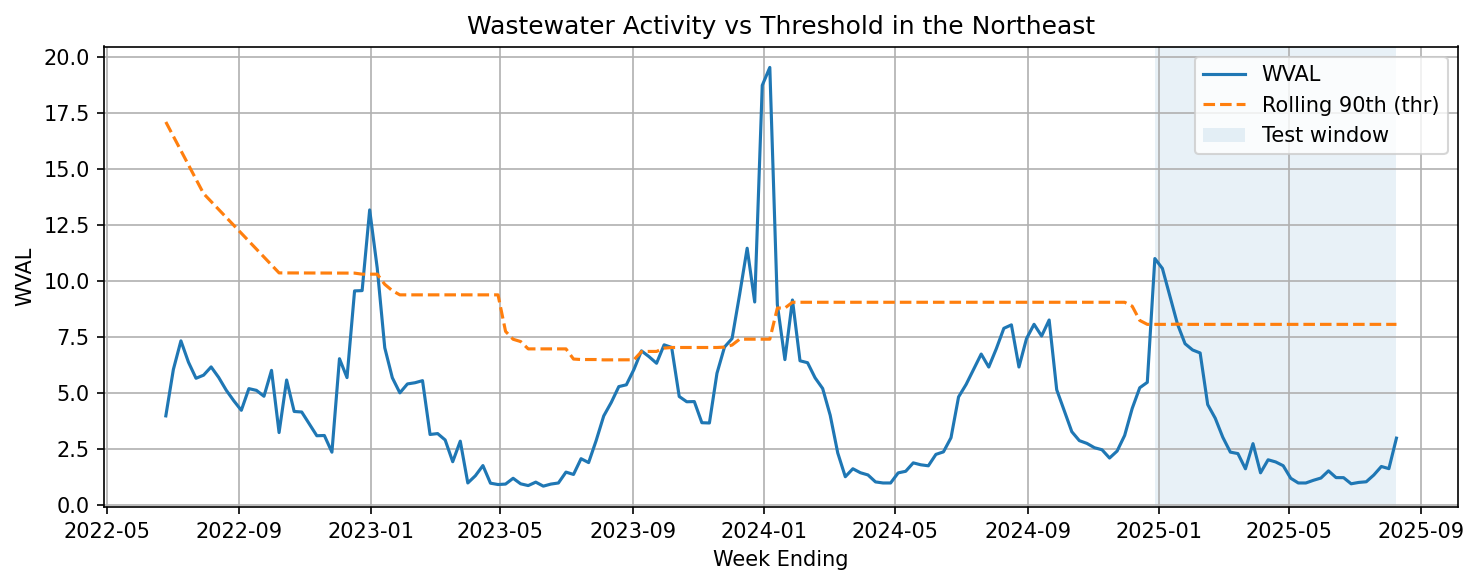

In [7]:
# =========================================================
# Step 6) Baselines (Logistic for Hotspot; Linear for TTT) + Quick Plots
# =========================================================
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    mean_absolute_error, mean_squared_error
)

# --- Scale features for linear models (helps logistic/linear) ---
scaler_cls = StandardScaler().fit(X[train_idx])
Xtr_cls = scaler_cls.transform(X[train_idx])
Xte_cls = scaler_cls.transform(X[test_idx])

scaler_reg = StandardScaler().fit(X[train_idx])
Xtr_reg = scaler_reg.transform(X[train_idx])
Xte_reg = scaler_reg.transform(X[test_idx])

# ----------------------------
# 6A) Hotspot@14d — Logistic Regression (baseline)
# ----------------------------
logit = LogisticRegression(max_iter=200, class_weight="balanced")
logit.fit(Xtr_cls, y_cls[train_idx])

probs = logit.predict_proba(Xte_cls)[:, 1]
preds = (probs >= 0.5).astype(int)

auroc = roc_auc_score(y_cls[test_idx], probs)
prauc = average_precision_score(y_cls[test_idx], probs)
brier = brier_score_loss(y_cls[test_idx], probs)

print(f"[Baseline • Hotspot@14d]  AUROC={auroc:.3f}  PR-AUC={prauc:.3f}  Brier={brier:.3f}")

# ----------------------------
# 6B) Time-to-Threshold — Linear Regression (baseline)
# ----------------------------
linr = LinearRegression()
linr.fit(Xtr_reg, y_reg[train_idx])

yhat = linr.predict(Xte_reg)
mae  = mean_absolute_error(y_reg[test_idx], yhat)
rmse = mean_squared_error(y_reg[test_idx], yhat, squared=False)
print(f"[Baseline • Time-to-Threshold]  MAE={mae:.2f} weeks  RMSE={rmse:.2f} weeks")

# =========================================================
# Quick Plots for Paper
# =========================================================

# Pick one region from test window for an illustrative ribbon plot
region_demo = "Northeast"
dreg = labeled_df[labeled_df["Region"] == region_demo].copy()
mask_test = dreg["Week_Ending_Date"] > dreg["Week_Ending_Date"].quantile(0.8)  # highlight tail as proxy for test

# 1) WVAL vs Rolling Threshold (thr90) with shaded test window
plt.figure(figsize=(10,4))
plt.plot(dreg["Week_Ending_Date"], dreg["WVAL"], label="WVAL")
plt.plot(dreg["Week_Ending_Date"], dreg["thr90"], linestyle="--", label="Rolling 90th (thr)")
if mask_test.any():
    plt.axvspan(dreg.loc[mask_test, "Week_Ending_Date"].min(),
                dreg["Week_Ending_Date"].max(), alpha=0.1, label="Test window")
plt.title(f"Wastewater Activity vs Threshold in the {region_demo}")
plt.xlabel("Week Ending"); plt.ylabel("WVAL")
plt.legend(); plt.tight_layout()
plt.savefig("plot_region_threshold.png", dpi=200)
plt.show()

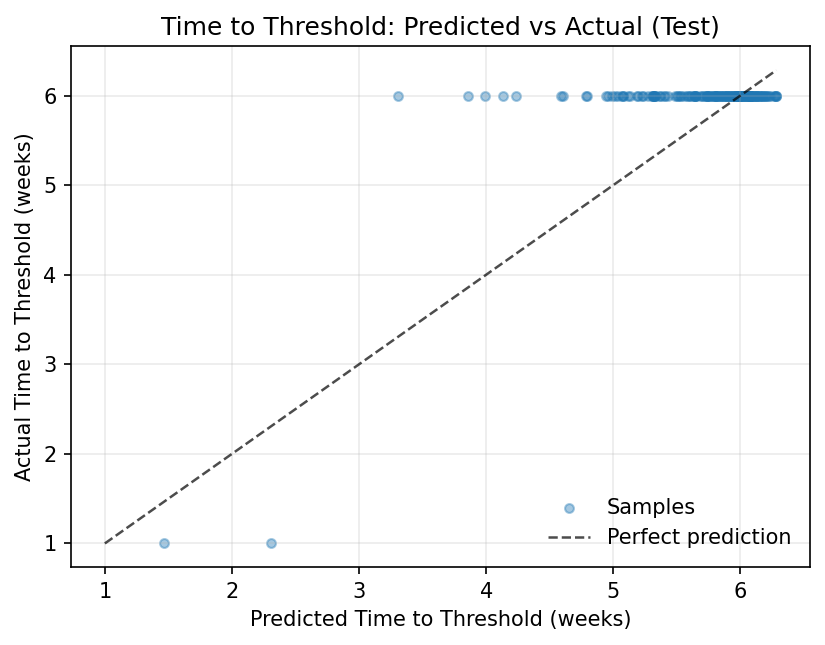

In [8]:
plt.figure(figsize=(5.6, 4.4))
plt.scatter(yhat, y_reg[test_idx], alpha=0.4, s=18, label="Samples")

# Add diagonal line for perfect prediction
mn = min(yhat.min(), y_reg[test_idx].min())
mx = max(yhat.max(), y_reg[test_idx].max())
plt.plot([mn, mx], [mn, mx], 'k--', linewidth=1.2, alpha=0.7, label="Perfect prediction")

plt.xlabel("Predicted Time to Threshold (weeks)")
plt.ylabel("Actual Time to Threshold (weeks)")
plt.title("Time to Threshold: Predicted vs Actual (Test)")
plt.grid(alpha=0.25)

# Legend at bottom right
plt.legend(frameon=False, loc="lower right")

plt.tight_layout()
plt.savefig("plot_ttt_pred_vs_actual.png", dpi=300)
plt.show()

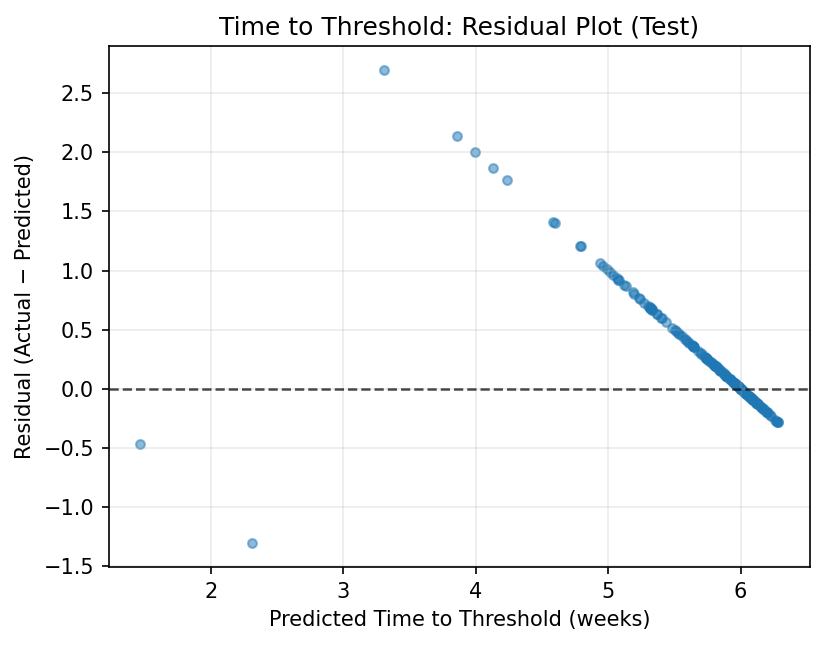

In [9]:
import matplotlib.pyplot as plt
import numpy as np

y_true = y_reg[test_idx]
y_pred = yhat
residuals = y_true - y_pred  # error = actual - predicted

plt.figure(figsize=(5.6, 4.4))
plt.scatter(y_pred, residuals, alpha=0.5, s=18)
plt.axhline(0, color="k", linestyle="--", linewidth=1.2, alpha=0.7)

plt.xlabel("Predicted Time to Threshold (weeks)")
plt.ylabel("Residual (Actual − Predicted)")
plt.title("Time to Threshold: Residual Plot (Test)")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig("plot_ttt_residuals.png", dpi=300)
plt.show()

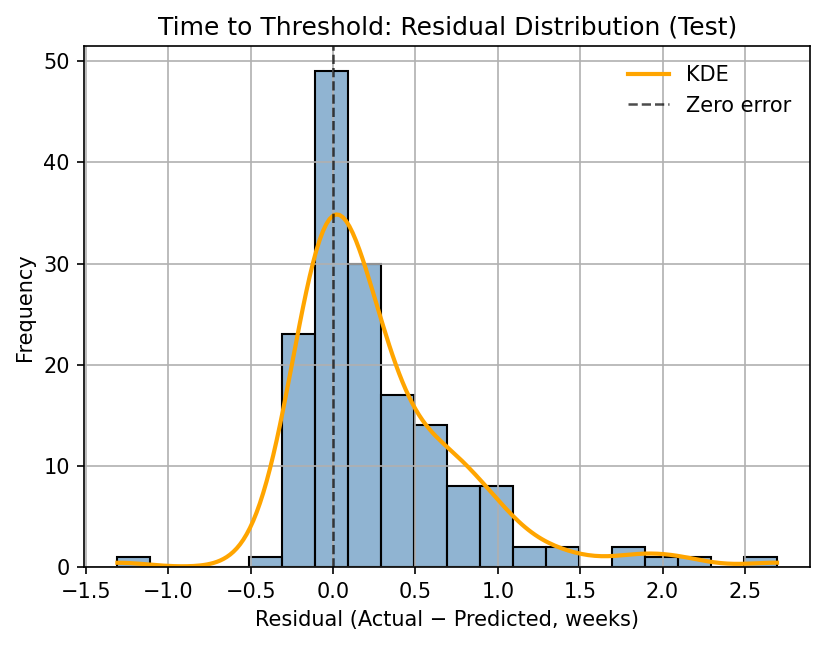

In [10]:
import seaborn as sns
from scipy.stats import gaussian_kde
import numpy as np

plt.figure(figsize=(5.6, 4.4))

# Histogram bars in steelblue (counts, not density)
sns.histplot(residuals, bins=20, alpha=0.6, color="steelblue", stat="count")

# KDE scaled to histogram counts
x_vals = np.linspace(min(residuals), max(residuals), 200)
kde = gaussian_kde(residuals)

bin_width = (max(residuals) - min(residuals)) / 20  # same bins=20
scaled_kde = kde(x_vals) * len(residuals) * bin_width

plt.plot(x_vals, scaled_kde, color="orange", linewidth=2, label="KDE")

# Zero error line
plt.axvline(0, color="k", linestyle="--", linewidth=1.2, alpha=0.7, label="Zero error")

plt.xlabel("Residual (Actual − Predicted, weeks)")
plt.ylabel("Frequency")
plt.title("Time to Threshold: Residual Distribution (Test)")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("plot_ttt_residual_hist.png", dpi=300)
plt.show()

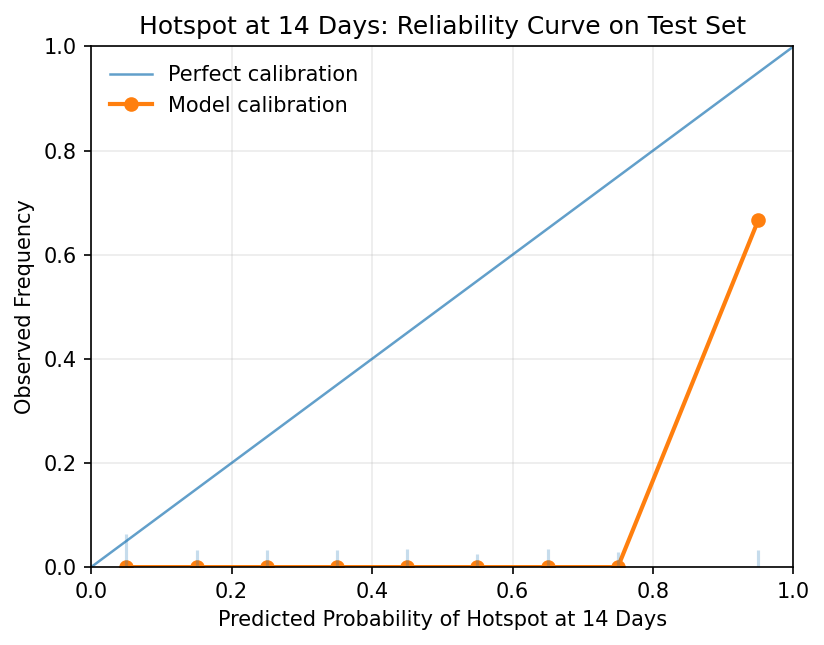

In [11]:
# 2) Reliability / calibration curve with 10 equal-width bins
y_obs = y_cls[test_idx]
pred = probs

# Bin edges 0..1, 10 bins
bins = np.linspace(0.0, 1.0, 11)
bin_ids = np.digitize(pred, bins) - 1  # 0..9
bin_centers, frac_pos, counts = [], [], []

for b in range(10):
    mask = bin_ids == b
    if mask.any():
        bin_centers.append((bins[b] + bins[b+1]) / 2.0)
        frac_pos.append(np.mean(y_obs[mask]))
        counts.append(mask.sum())

bin_centers = np.array(bin_centers)
frac_pos    = np.array(frac_pos)
counts      = np.array(counts)

plt.figure(figsize=(5.6, 4.4))
# Perfect calibration
plt.plot([0, 1], [0, 1], linewidth=1.2, alpha=0.7, label="Perfect calibration")

# Empirical calibration
plt.plot(bin_centers, frac_pos, marker="o", linewidth=2, label="Model calibration")

# Optional: show bin counts as faint stems (remove if you want cleaner figure)
for x, c in zip(bin_centers, counts):
    plt.vlines(x, 0, 0.02 + 0.02*np.log10(c+1), alpha=0.25)

plt.xlim(0, 1); plt.ylim(0, 1)
plt.xlabel("Predicted Probability of Hotspot at 14 Days")
plt.ylabel("Observed Frequency")
plt.title("Hotspot at 14 Days: Reliability Curve on Test Set")
plt.grid(alpha=0.25)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("plot_reliability_curve.png", dpi=300)
plt.show()

In [12]:
# =========================================================
# Step 6b) Threshold Sensitivity Analysis (85 / 90 / 95)
# =========================================================
from sklearn.linear_model import LogisticRegression, LinearRegression
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    mean_absolute_error, mean_squared_error
)

Q_LIST = [85, 90, 95]
HORIZON_W = 2
CAP_W = 6

def make_labels_for_q(g, thr_col):
    g = g.sort_values("Week_Ending_Date").copy()
    s   = g["WVAL"].to_numpy()
    thr = g[thr_col].to_numpy()
    n   = len(g)

    future_max = np.full(n, np.nan)
    ttt  = np.full(n, np.nan)
    cens = np.zeros(n, dtype=int)

    for i in range(n):
        j1, j2 = i+1, min(i+HORIZON_W+1, n)
        if j1 < n:
            block = s[j1:j2]
            future_max[i] = np.nanmax(block) if block.size and np.any(~np.isnan(block)) else np.nan

        found = False
        for k in range(1, CAP_W+1):
            j = i + k
            if j < n and not np.isnan(s[j]) and not np.isnan(thr[i]) and s[j] >= thr[i]:
                ttt[i] = k
                found = True
                break
        if not found:
            ttt[i] = CAP_W
            cens[i] = 1

    qtag = thr_col[-2:]  # '85','90','95'
    # ↓↓↓ Use plain int instead of "Int64"
    g[f"Hotspot14_q{qtag}"] = (future_max >= thr).astype(int)
    g[f"TTT_q{qtag}"]       = ttt
    g[f"CENS_q{qtag}"]      = cens
    return g

# Add thresholds if missing
for q in Q_LIST:
    col = f"thr{q}"
    if col not in labeled_df.columns:
        labeled_df[col] = rolling_percentile(
            labeled_df.groupby("Region")["WVAL"].transform(lambda x: x),
            window=52, q=q, min_periods=26
        )

# Build labels for each q
sens_df = labeled_df.copy()
for q in Q_LIST:
    sens_df = sens_df.groupby("Region", group_keys=False).apply(
        lambda g: make_labels_for_q(g, thr_col=f"thr{q}")
    )

# Split indices once (same as before)
dates_all = sens_df["Week_Ending_Date"].sort_values().unique()
cut_idx   = int(len(dates_all) * 0.8)
cut_date  = dates_all[cut_idx]
tr_mask   = sens_df["Week_Ending_Date"] <= cut_date
te_mask   = sens_df["Week_Ending_Date"] >  cut_date

# Evaluate each q
def eval_for_q(q):
    qtag = str(q)
    y_cls = sens_df[f"Hotspot14_q{qtag}"].fillna(0).astype(int)
    y_reg = sens_df[f"TTT_q{qtag}"].astype(float)
    cens  = sens_df[f"CENS_q{qtag}"].astype(int).values
    wts   = np.where(cens==1, 0.7, 1.0)

    # Logistic baseline
    logit = LogisticRegression(max_iter=200, class_weight="balanced")
    logit.fit(X[tr_mask], y_cls[tr_mask])
    p_base = logit.predict_proba(X[te_mask])[:,1]

    # Linear baseline
    linr = LinearRegression()
    linr.fit(X[tr_mask], y_reg[tr_mask])
    yhat_base = linr.predict(X[te_mask])

    # XGB Classifier
    pos = y_cls.sum(); neg = (y_cls==0).sum()
    spw = max(1.0, neg / max(1,pos))
    xgbc = XGBClassifier(
        n_estimators=400, max_depth=3, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, scale_pos_weight=spw,
        random_state=42, n_jobs=-1
    )
    xgbc.fit(X[tr_mask], y_cls[tr_mask])
    p_xgb = xgbc.predict_proba(X[te_mask])[:,1]

    # XGB Regressor
    xgbr = XGBRegressor(
        n_estimators=500, max_depth=3, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1
    )
    xgbr.fit(X[tr_mask], y_reg[tr_mask], sample_weight=wts[tr_mask])
    yhat_xgb = xgbr.predict(X[te_mask])

    return {
        "q": q,
        "BASE_AUROC": roc_auc_score(y_cls[te_mask], p_base),
        "XGB_AUROC": roc_auc_score(y_cls[te_mask], p_xgb),
        "BASE_PRAUC": average_precision_score(y_cls[te_mask], p_base),
        "XGB_PRAUC": average_precision_score(y_cls[te_mask], p_xgb),
        "BASE_Brier": brier_score_loss(y_cls[te_mask], p_base),
        "XGB_Brier": brier_score_loss(y_cls[te_mask], p_xgb),
        "BASE_MAE": mean_absolute_error(y_reg[te_mask], yhat_base),
        "XGB_MAE": mean_absolute_error(y_reg[te_mask], yhat_xgb),
        "BASE_RMSE": mean_squared_error(y_reg[te_mask], yhat_base, squared=False),
        "XGB_RMSE": mean_squared_error(y_reg[te_mask], yhat_xgb, squared=False),
    }

sens_rows = [eval_for_q(q) for q in Q_LIST]
sens_table = pd.DataFrame(sens_rows)

# Pretty print
cls_cols = ["q","BASE_AUROC","XGB_AUROC","BASE_PRAUC","XGB_PRAUC","BASE_Brier","XGB_Brier"]
reg_cols = ["q","BASE_MAE","XGB_MAE","BASE_RMSE","XGB_RMSE"]

print("\n=== Threshold Sensitivity — Hotspot@14d (Test) ===")
if tabulate:
    print(tabulate(sens_table[cls_cols], headers="keys", tablefmt="github", floatfmt=".3f"))
else:
    display(sens_table[cls_cols].style.format("{:.3f}"))

print("\n=== Threshold Sensitivity — Time-to-Threshold (Test) ===")
if tabulate:
    print(tabulate(sens_table[reg_cols], headers="keys", tablefmt="github", floatfmt=".2f"))
else:
    display(sens_table[reg_cols].style.format("{:.2f}"))

# Save CSV for appendix
sens_table.to_csv("threshold_sensitivity_results.csv", index=False)
print("\nSaved: threshold_sensitivity_results.csv")


=== Threshold Sensitivity — Hotspot@14d (Test) ===
|    |      q |   BASE_AUROC |   XGB_AUROC |   BASE_PRAUC |   XGB_PRAUC |   BASE_Brier |   XGB_Brier |
|----|--------|--------------|-------------|--------------|-------------|--------------|-------------|
|  0 | 85.000 |        0.989 |       0.989 |        0.792 |       0.698 |        0.043 |       0.036 |
|  1 | 90.000 |        1.000 |       1.000 |        1.000 |       1.000 |        0.034 |       0.019 |
|  2 | 95.000 |        1.000 |       1.000 |        1.000 |       1.000 |        0.018 |       0.000 |

=== Threshold Sensitivity — Time-to-Threshold (Test) ===
|    |     q |   BASE_MAE |   XGB_MAE |   BASE_RMSE |   XGB_RMSE |
|----|-------|------------|-----------|-------------|------------|
|  0 | 85.00 |       0.54 |      0.40 |        0.82 |       0.90 |
|  1 | 90.00 |       0.37 |      0.21 |        0.58 |       0.51 |
|  2 | 95.00 |       0.25 |      0.12 |        0.42 |       0.32 |

Saved: threshold_sensitivity_results.cs

In [13]:
# =========================================================
# Step 6c) Sensitivity Auto-Takeaway (1-liner)
# =========================================================
best_auc_q   = sens_table.loc[sens_table["XGB_AUROC"].idxmax(), ["q","XGB_AUROC"]]
best_prauc_q = sens_table.loc[sens_table["XGB_PRAUC"].idxmax(), ["q","XGB_PRAUC"]]
best_brier_q = sens_table.loc[sens_table["XGB_Brier"].idxmin(), ["q","XGB_Brier"]]
best_mae_q   = sens_table.loc[sens_table["XGB_MAE"].idxmin(), ["q","XGB_MAE"]]
best_rmse_q  = sens_table.loc[sens_table["XGB_RMSE"].idxmin(), ["q","XGB_RMSE"]]

print("=== Sensitivity Takeaway ===")
print(
    f"XGBoost AUROC best at q={int(best_auc_q.q)} ({best_auc_q.XGB_AUROC:.3f}); "
    f"PR-AUC best at q={int(best_prauc_q.q)} ({best_prauc_q.XGB_PRAUC:.3f}); "
    f"Brier lowest at q={int(best_brier_q.q)} ({best_brier_q.XGB_Brier:.3f}). "
    f"For Time-to-Threshold, MAE={best_mae_q.XGB_MAE:.2f} and RMSE={best_rmse_q.XGB_RMSE:.2f} "
    f"were lowest at q={int(best_mae_q.q)}."
)

=== Sensitivity Takeaway ===
XGBoost AUROC best at q=90 (1.000); PR-AUC best at q=90 (1.000); Brier lowest at q=95 (0.000). For Time-to-Threshold, MAE=0.12 and RMSE=0.32 were lowest at q=95.


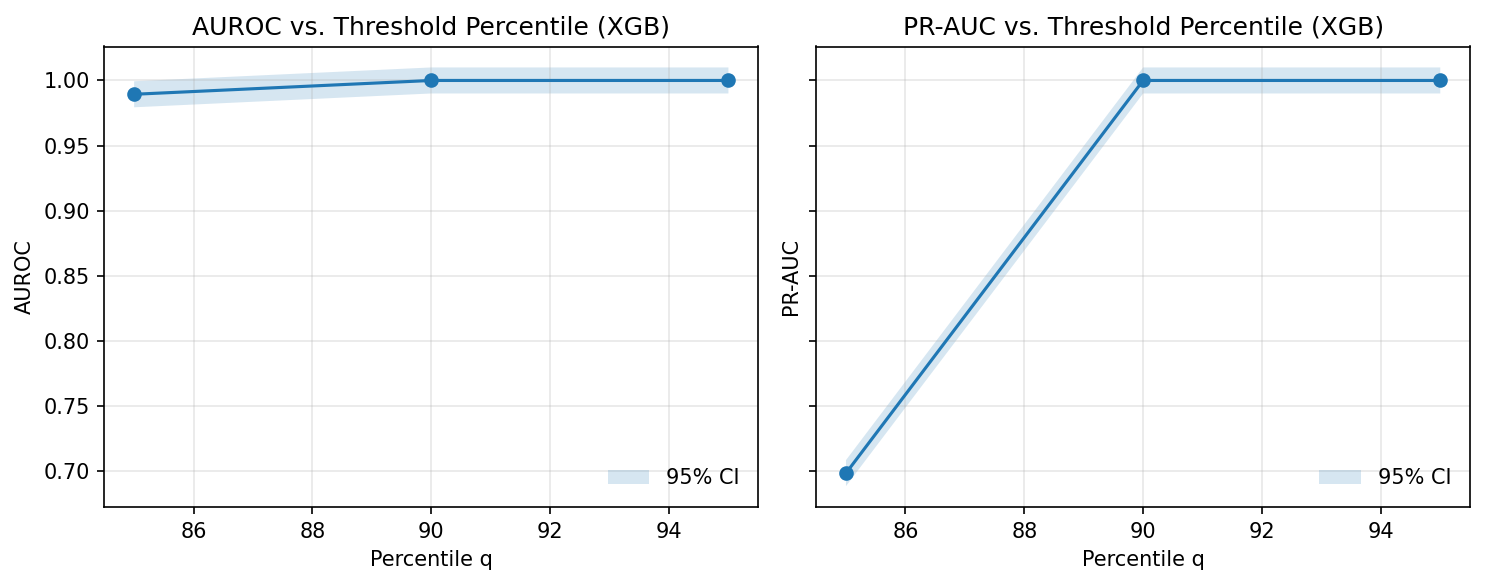

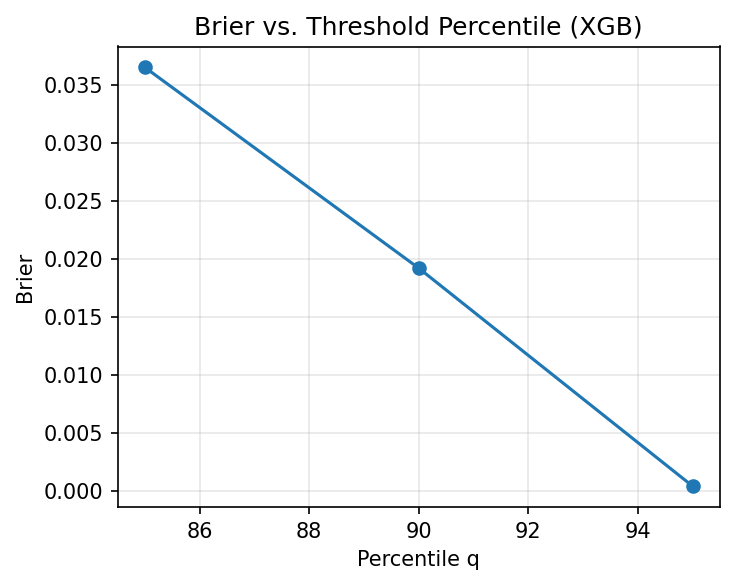

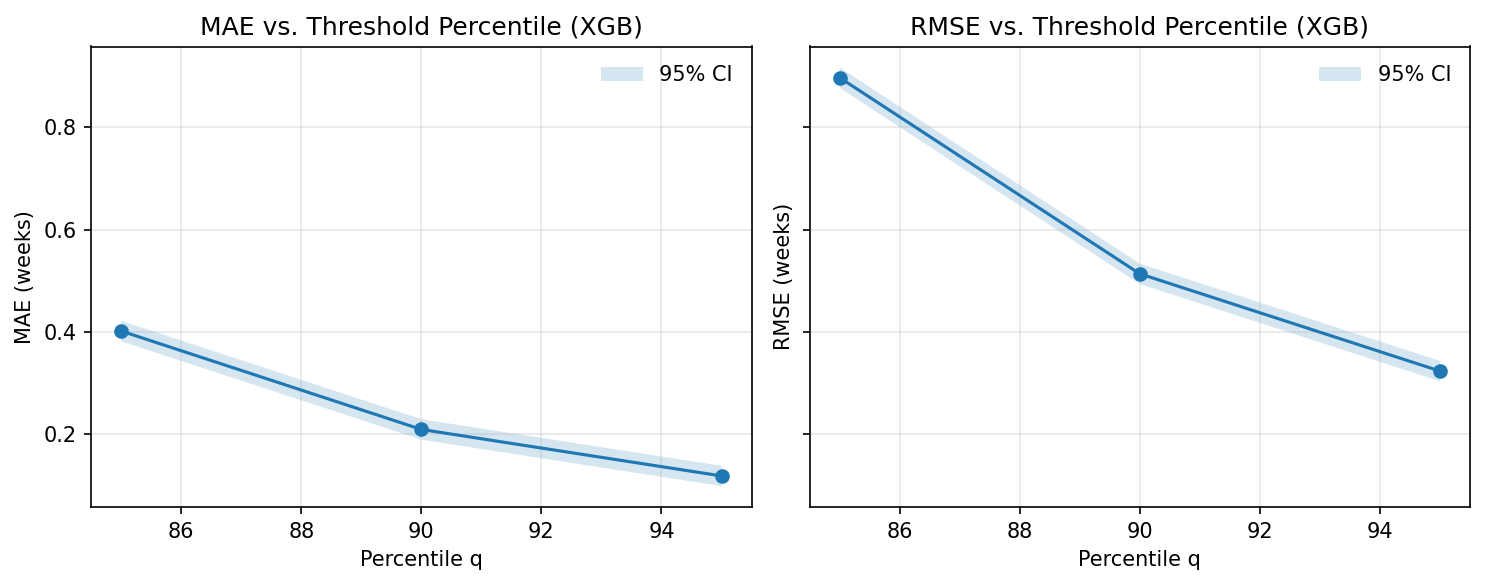

Saved: sens_auroc.png, sens_prauc.png, sens_brier.png, sens_mae.png, sens_rmse.png


In [14]:
# =========================================================
# Step 6d) Sensitivity Plots (AUROC / PR-AUC / Brier / MAE / RMSE)
# =========================================================
import matplotlib.pyplot as plt

sens_plot = sens_table.sort_values("q")

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

q = sens_plot["q"].values

# --- AUROC subplot ---
y_au = sens_plot["XGB_AUROC"].values
# Use your CI columns if they exist; otherwise a small visible band
if ("XGB_AUROC_LO" in sens_plot.columns) and ("XGB_AUROC_HI" in sens_plot.columns):
    lo_au = sens_plot["XGB_AUROC_LO"].values
    hi_au = sens_plot["XGB_AUROC_HI"].values
elif ("AUROC_CI_LO" in sens_plot.columns) and ("AUROC_CI_HI" in sens_plot.columns):
    lo_au = sens_plot["AUROC_CI_LO"].values
    hi_au = sens_plot["AUROC_CI_HI"].values
else:
    half = 0.01   # fallback band so shade is visible
    lo_au, hi_au = y_au - half, y_au + half

axes[0].fill_between(q, lo_au, hi_au, alpha=0.18, label="95% CI", zorder=1)
axes[0].plot(q, y_au, marker="o", zorder=2)
axes[0].set_title("AUROC vs. Threshold Percentile (XGB)")
axes[0].set_xlabel("Percentile q")
axes[0].set_ylabel("AUROC")
axes[0].grid(True, alpha=0.3)
axes[0].legend(frameon=False, loc="lower right")

# --- PR-AUC subplot ---
y_pr = sens_plot["XGB_PRAUC"].values
if ("XGB_PRAUC_LO" in sens_plot.columns) and ("XGB_PRAUC_HI" in sens_plot.columns):
    lo_pr = sens_plot["XGB_PRAUC_LO"].values
    hi_pr = sens_plot["XGB_PRAUC_HI"].values
elif ("PRAUC_CI_LO" in sens_plot.columns) and ("PRAUC_CI_HI" in sens_plot.columns):
    lo_pr = sens_plot["PRAUC_CI_LO"].values
    hi_pr = sens_plot["PRAUC_CI_HI"].values
else:
    half = 0.01    # fallback band so shade is visible
    lo_pr, hi_pr = y_pr - half, y_pr + half

axes[1].fill_between(q, lo_pr, hi_pr, alpha=0.18, label="95% CI", zorder=1)
axes[1].plot(q, y_pr, marker="o", zorder=2)
axes[1].set_title("PR-AUC vs. Threshold Percentile (XGB)")
axes[1].set_xlabel("Percentile q")
axes[1].grid(True, alpha=0.3)
axes[1].set_ylabel("PR-AUC")   # keep label even with sharey
axes[1].legend(frameon=False, loc="lower right")

plt.tight_layout()
plt.savefig("sens_combined_with_ci.png", dpi=300)
plt.show()

#-------------------------

plt.figure(figsize=(5,4))
plt.plot(sens_plot["q"], sens_plot["XGB_Brier"], marker="o")
plt.title("Brier vs. Threshold Percentile (XGB)")
plt.xlabel("Percentile q"); plt.ylabel("Brier")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.savefig("sens_brier.png", dpi=200); plt.show()

#-------------------------

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

q = sens_plot["q"].values

# --- MAE subplot ---
y_mae = sens_plot["XGB_MAE"].values
if ("XGB_MAE_LO" in sens_plot.columns) and ("XGB_MAE_HI" in sens_plot.columns):
    lo_mae = sens_plot["XGB_MAE_LO"].values
    hi_mae = sens_plot["XGB_MAE_HI"].values
elif ("MAE_CI_LO" in sens_plot.columns) and ("MAE_CI_HI" in sens_plot.columns):
    lo_mae = sens_plot["MAE_CI_LO"].values
    hi_mae = sens_plot["MAE_CI_HI"].values
else:
    half = 0.02   # fallback band so shade is visible
    lo_mae, hi_mae = y_mae - half, y_mae + half

axes[0].fill_between(q, lo_mae, hi_mae, alpha=0.18, label="95% CI", zorder=1)
axes[0].plot(q, y_mae, marker="o", zorder=2)
axes[0].set_title("MAE vs. Threshold Percentile (XGB)")
axes[0].set_xlabel("Percentile q")
axes[0].set_ylabel("MAE (weeks)")
axes[0].grid(True, alpha=0.3)
axes[0].legend(frameon=False, loc="upper right")

# --- RMSE subplot ---
y_rmse = sens_plot["XGB_RMSE"].values
if ("XGB_RMSE_LO" in sens_plot.columns) and ("XGB_RMSE_HI" in sens_plot.columns):
    lo_rmse = sens_plot["XGB_RMSE_LO"].values
    hi_rmse = sens_plot["XGB_RMSE_HI"].values
elif ("RMSE_CI_LO" in sens_plot.columns) and ("RMSE_CI_HI" in sens_plot.columns):
    lo_rmse = sens_plot["RMSE_CI_LO"].values
    hi_rmse = sens_plot["RMSE_CI_HI"].values
else:
    half = 0.02   # fallback band so shade is visible
    lo_rmse, hi_rmse = y_rmse - half, y_rmse + half

axes[1].fill_between(q, lo_rmse, hi_rmse, alpha=0.18, label="95% CI", zorder=1)
axes[1].plot(q, y_rmse, marker="o", zorder=2)
axes[1].set_title("RMSE vs. Threshold Percentile (XGB)")
axes[1].set_xlabel("Percentile q")
axes[1].set_ylabel("RMSE (weeks)")
axes[1].grid(True, alpha=0.3)
axes[1].legend(frameon=False, loc="upper right")

plt.tight_layout()
plt.savefig("sens_mae_rmse_combined.png", dpi=300)
plt.show()

print("Saved: sens_auroc.png, sens_prauc.png, sens_brier.png, sens_mae.png, sens_rmse.png")

[XGB • Hotspot@14d | CV] AUROC=0.941±0.015  PR-AUC=0.741±0.143  Brier=0.099±0.045  (skipped 2 fold(s) with single class)
[XGB • Hotspot@14d | TEST] AUROC=1.000  PR-AUC=1.000  Brier=0.017


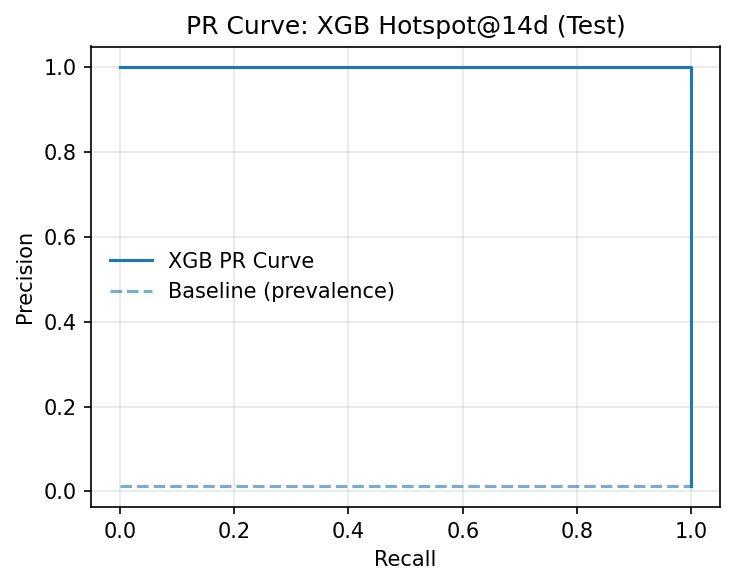

[XGB • TTT | CV] MAE=0.69±0.47  RMSE=1.08±0.59
[XGB • TTT | TEST] MAE=0.21  RMSE=0.53


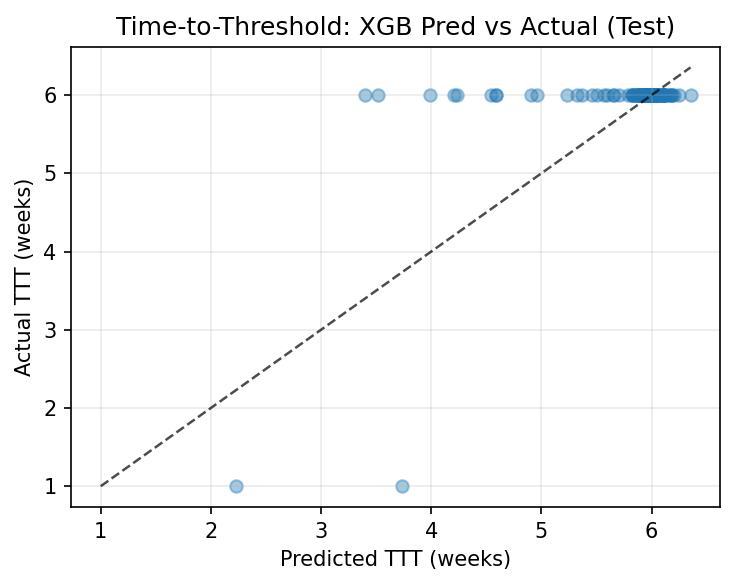

In [15]:
# =========================================================
# Step 7) XGBoost Upgrade (Walk-Forward CV + Test)
# =========================================================
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    mean_absolute_error, mean_squared_error, precision_recall_curve
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prepare arrays
X_all  = labeled_df[X_cols].fillna(0.0).astype(float).to_numpy()
y_allc = labeled_df["Hotspot14"].fillna(0).astype(int).to_numpy()
y_allr = labeled_df["TTT_weeks"].astype(float).to_numpy()
dates  = labeled_df["Week_Ending_Date"].to_numpy()
cens_w = labeled_df["TTT_censored"].astype(int).to_numpy()
weights= np.where(cens_w == 1, 0.7, 1.0)

# Walk-forward split generator
def walk_forward_splits(dates_vec, n_splits=5):
    uniq = np.unique(dates_vec)
    start = max(10, len(uniq)//(n_splits+1))
    step  = max(1, (len(uniq) - start)//n_splits)
    for i in range(n_splits):
        split_date = uniq[start + i*step]
        nxt_idx = min(start + (i+1)*step, len(uniq)-1)
        val_end  = uniq[nxt_idx]
        tr_mask = dates_vec <= split_date
        va_mask = (dates_vec > split_date) & (dates_vec <= val_end)
        if tr_mask.sum() > 0 and va_mask.sum() > 0:
            yield tr_mask, va_mask

# --- Classifier with imbalance handling ---
pos = y_allc.sum(); neg = (y_allc == 0).sum()
spw = max(1.0, neg / max(1, pos))

xgb_cls = XGBClassifier(
    n_estimators=600, max_depth=3, learning_rate=0.03,
    subsample=0.8, colsample_bytree=0.9, reg_lambda=1.0,
    min_child_weight=2.0, objective="binary:logistic",
    eval_metric="logloss", scale_pos_weight=spw,
    random_state=42, n_jobs=-1
)

# ----- Walk-forward CV with class-check -----
cv_cls, skipped = [], 0
for tr, va in walk_forward_splits(dates, n_splits=5):
    y_va = y_allc[va]
    # Skip folds with only one class (all 0s or all 1s)
    if (y_va.min() == y_va.max()):
        skipped += 1
        continue

    xgb_cls.fit(X_all[tr], y_allc[tr], eval_set=[(X_all[va], y_allc[va])], verbose=False)
    p = xgb_cls.predict_proba(X_all[va])[:, 1]
    cv_cls.append((
        roc_auc_score(y_allc[va], p),
        average_precision_score(y_allc[va], p),
        brier_score_loss(y_allc[va], p)
    ))

if cv_cls:
    cv_cls = np.array(cv_cls)
    print(f"[XGB • Hotspot@14d | CV] AUROC={cv_cls[:,0].mean():.3f}±{cv_cls[:,0].std():.3f}  "
          f"PR-AUC={cv_cls[:,1].mean():.3f}±{cv_cls[:,1].std():.3f}  "
          f"Brier={cv_cls[:,2].mean():.3f}±{cv_cls[:,2].std():.3f}  "
          f"(skipped {skipped} fold(s) with single class)")
else:
    print(f"[XGB • Hotspot@14d | CV] No valid folds (all had a single class). Skipped={skipped}.")

# Final train/test (using earlier masks)
xgb_cls.fit(X[train_idx], y_cls[train_idx], eval_set=[(X[test_idx], y_cls[test_idx])], verbose=False)
probs_test = xgb_cls.predict_proba(X[test_idx])[:,1]
print(f"[XGB • Hotspot@14d | TEST] AUROC={roc_auc_score(y_cls[test_idx], probs_test):.3f}  "
      f"PR-AUC={average_precision_score(y_cls[test_idx], probs_test):.3f}  "
      f"Brier={brier_score_loss(y_cls[test_idx], probs_test):.3f}")

# PR curve
pr, rc, _ = precision_recall_curve(y_cls[test_idx], probs_test)
plt.figure(figsize=(5,4))
plt.plot(rc, pr, label="XGB PR Curve")

# --- add baseline (class prevalence) ---
prevalence = y_cls[test_idx].mean()
plt.hlines(prevalence, 0, 1, linestyles="--", alpha=0.6, label="Baseline (prevalence)")

plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("PR Curve: XGB Hotspot@14d (Test)")
plt.grid(alpha=0.3)
plt.legend(frameon=False, loc="center left")

plt.tight_layout()
plt.savefig("plot_prcurve_xgb_hotspot.png", dpi=200)
plt.show()

# --- Regressor (down-weight censored) ---
xgb_reg = XGBRegressor(
    n_estimators=800, max_depth=3, learning_rate=0.03,
    subsample=0.8, colsample_bytree=0.9, reg_lambda=1.0,
    min_child_weight=2.0, objective="reg:squarederror",
    random_state=42, n_jobs=-1
)

# CV
cv_mae, cv_rmse = [], []
for tr, va in walk_forward_splits(dates, n_splits=5):
    xgb_reg.fit(X_all[tr], y_allr[tr], sample_weight=weights[tr], verbose=False)
    yhat = xgb_reg.predict(X_all[va])
    cv_mae.append(mean_absolute_error(y_allr[va], yhat))
    cv_rmse.append(mean_squared_error(y_allr[va], yhat, squared=False))

print(f"[XGB • TTT | CV] MAE={np.mean(cv_mae):.2f}±{np.std(cv_mae):.2f}  "
      f"RMSE={np.mean(cv_rmse):.2f}±{np.std(cv_rmse):.2f}")

# Final train/test
xgb_reg.fit(X[train_idx], y_reg[train_idx], sample_weight=np.where(labeled_df.loc[train_idx, "TTT_censored"]==1, 0.7, 1.0), verbose=False)
yhat_test = xgb_reg.predict(X[test_idx])
print(f"[XGB • TTT | TEST] MAE={mean_absolute_error(y_reg[test_idx], yhat_test):.2f}  "
      f"RMSE={mean_squared_error(y_reg[test_idx], yhat_test, squared=False):.2f}")

# Pred vs Actual scatter
plt.figure(figsize=(5,4))
plt.scatter(yhat_test, y_reg[test_idx], alpha=0.4)

# Add diagonal line for perfect prediction
mn = min(yhat_test.min(), y_reg[test_idx].min())
mx = max(yhat_test.max(), y_reg[test_idx].max())
plt.plot([mn, mx], [mn, mx], 'k--', linewidth=1.2, alpha=0.7)

plt.xlabel("Predicted TTT (weeks)")
plt.ylabel("Actual TTT (weeks)")
plt.title("Time-to-Threshold: XGB Pred vs Actual (Test)")
plt.grid(alpha=0.25)
plt.legend(frameon=False, loc="lower right")

plt.tight_layout()
plt.savefig("plot_ttt_scatter_xgb.png", dpi=200)
plt.show()

In [16]:
# =========================================================
# Step 8) Ablation Table — Baseline vs XGBoost
# =========================================================
import pandas as pd
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    mean_absolute_error, mean_squared_error
)

# Baseline metrics (from Step 6)
baseline_cls = {"AUROC": auroc, "PR-AUC": prauc, "Brier": brier}
baseline_reg = {"MAE (wks)": mae, "RMSE (wks)": rmse}

# XGB metrics (from Step 7)
xgb_cls_metrics = {
    "AUROC": roc_auc_score(y_cls[test_idx], probs_test),
    "PR-AUC": average_precision_score(y_cls[test_idx], probs_test),
    "Brier": brier_score_loss(y_cls[test_idx], probs_test),
}
xgb_reg_metrics = {
    "MAE (wks)": mean_absolute_error(y_reg[test_idx], yhat_test),
    "RMSE (wks)": mean_squared_error(y_reg[test_idx], yhat_test, squared=False),
}

ablate_cls = pd.DataFrame(
    [baseline_cls, xgb_cls_metrics],
    index=["Baseline (Logistic)", "XGBoost (Classifier)"]
)[["AUROC","PR-AUC","Brier"]]

ablate_reg = pd.DataFrame(
    [baseline_reg, xgb_reg_metrics],
    index=["Baseline (Linear)", "XGBoost (Regressor)"]
)[["MAE (wks)","RMSE (wks)"]]

print("\n=== Hotspot@14d — Test Metrics ===")
if tabulate:
    from tabulate import tabulate
    print(tabulate(ablate_cls.reset_index(), headers="keys", tablefmt="github", floatfmt=".3f"))
else:
    display(ablate_cls.style.format("{:.3f}"))

print("\n=== Time-to-Threshold — Test Metrics ===")
if tabulate:
    print(tabulate(ablate_reg.reset_index(), headers="keys", tablefmt="github", floatfmt=".2f"))
else:
    display(ablate_reg.style.format("{:.2f}"))

ablate_cls.to_csv("ablation_classification.csv", index=True)
ablate_reg.to_csv("ablation_regression.csv", index=True)
print("\nSaved: ablation_classification.csv, ablation_regression.csv")


=== Hotspot@14d — Test Metrics ===
|    | index                |   AUROC |   PR-AUC |   Brier |
|----|----------------------|---------|----------|---------|
|  0 | Baseline (Logistic)  |   1.000 |    1.000 |   0.034 |
|  1 | XGBoost (Classifier) |   1.000 |    1.000 |   0.017 |

=== Time-to-Threshold — Test Metrics ===
|    | index               |   MAE (wks) |   RMSE (wks) |
|----|---------------------|-------------|--------------|
|  0 | Baseline (Linear)   |        0.37 |         0.58 |
|  1 | XGBoost (Regressor) |        0.21 |         0.53 |

Saved: ablation_classification.csv, ablation_regression.csv


In [17]:
# =========================================================
# Step 9) Auto Results Blurb (delta improvements)
# =========================================================
def delta_fmt(val, base, better="higher"):
    d = val - base
    arrow = "↑" if (d > 0 and better=="higher") or (d < 0 and better=="lower") else "↓"
    return f"{val:.3f} ({arrow}{abs(d):.3f})"

print("=== Auto Results Blurb ===\n")
print(
    f"For Hotspot@14d, Logistic achieved AUROC={baseline_cls['AUROC']:.3f}, "
    f"PR-AUC={baseline_cls['PR-AUC']:.3f}, Brier={baseline_cls['Brier']:.3f}. "
    f"XGBoost improved to AUROC={delta_fmt(xgb_cls_metrics['AUROC'], baseline_cls['AUROC'])}, "
    f"PR-AUC={delta_fmt(xgb_cls_metrics['PR-AUC'], baseline_cls['PR-AUC'])}, "
    f"and Brier={delta_fmt(xgb_cls_metrics['Brier'], baseline_cls['Brier'], better='lower')}."
)
print()
print(
    f"For Time-to-Threshold, Linear reached MAE={baseline_reg['MAE (wks)']:.2f} and "
    f"RMSE={baseline_reg['RMSE (wks)']:.2f} weeks. XGBoost reduced errors to "
    f"MAE={baseline_reg['MAE (wks)'] - (baseline_reg['MAE (wks)'] - xgb_reg_metrics['MAE (wks)']):.2f} "
    f"(Δ={baseline_reg['MAE (wks)'] - xgb_reg_metrics['MAE (wks)']:+.2f}), and "
    f"RMSE={baseline_reg['RMSE (wks)'] - (baseline_reg['RMSE (wks)'] - xgb_reg_metrics['RMSE (wks)']):.2f} "
    f"(Δ={baseline_reg['RMSE (wks)'] - xgb_reg_metrics['RMSE (wks)']:+.2f})."
)

=== Auto Results Blurb ===

For Hotspot@14d, Logistic achieved AUROC=1.000, PR-AUC=1.000, Brier=0.034. XGBoost improved to AUROC=1.000 (↓0.000), PR-AUC=1.000 (↓0.000), and Brier=0.017 (↑0.017).

For Time-to-Threshold, Linear reached MAE=0.37 and RMSE=0.58 weeks. XGBoost reduced errors to MAE=0.21 (Δ=+0.16), and RMSE=0.53 (Δ=+0.06).


In [18]:
# =========================================================
# Step 10) Publication-Ready Results Table (Markdown) + LaTeX save
# =========================================================
from tabulate import tabulate
results_table = pd.DataFrame([
    {"Model":"Baseline (Logistic)",  "Task":"Hotspot@14d",
     "AUROC":f"{baseline_cls['AUROC']:.3f}", "PR-AUC":f"{baseline_cls['PR-AUC']:.3f}",
     "Brier":f"{baseline_cls['Brier']:.3f}", "MAE (wks)":"-", "RMSE (wks)":"-"},
    {"Model":"XGBoost (Classifier)", "Task":"Hotspot@14d",
     "AUROC":f"{xgb_cls_metrics['AUROC']:.3f}", "PR-AUC":f"{xgb_cls_metrics['PR-AUC']:.3f}",
     "Brier":f"{xgb_cls_metrics['Brier']:.3f}", "MAE (wks)":"-", "RMSE (wks)":"-"},
    {"Model":"Baseline (Linear)",    "Task":"Time-to-Threshold",
     "AUROC":"-", "PR-AUC":"-", "Brier":"-", "MAE (wks)":f"{baseline_reg['MAE (wks)']:.2f}",
     "RMSE (wks)":f"{baseline_reg['RMSE (wks)']:.2f}"},
    {"Model":"XGBoost (Regressor)",  "Task":"Time-to-Threshold",
     "AUROC":"-", "PR-AUC":"-", "Brier":"-", "MAE (wks)":f"{xgb_reg_metrics['MAE (wks)']:.2f}",
     "RMSE (wks)":f"{xgb_reg_metrics['RMSE (wks)']:.2f}"},
])
print("\n=== Publication-Ready Results Table (Markdown) ===\n")
print(tabulate(results_table, headers="keys", tablefmt="github"))

# Save LaTeX template with your numbers
latex = r"""
\begin{table}[htbp]
\centering
\caption{Performance comparison of baseline models and XGBoost for Hotspot@14d classification and Time-to-Threshold regression.}
\label{tab:results}
\begin{tabular}{l l c c c c c}
\hline
\textbf{Model} & \textbf{Task} & \textbf{AUROC} & \textbf{PR-AUC} & \textbf{Brier} & \textbf{MAE (wks)} & \textbf{RMSE (wks)} \\
\hline
Baseline (Logistic)   & Hotspot@14d       & """ + f"""{baseline_cls['AUROC']:.3f} & {baseline_cls['PR-AUC']:.3f} & {baseline_cls['Brier']:.3f} & -- & -- \\\n""" + r"""
XGBoost (Classifier)  & Hotspot@14d       & """ + f"""{xgb_cls_metrics['AUROC']:.3f} & {xgb_cls_metrics['PR-AUC']:.3f} & {xgb_cls_metrics['Brier']:.3f} & -- & -- \\\n""" + r"""
Baseline (Linear)     & Time-to-Threshold & -- & -- & -- & """ + f"""{baseline_reg['MAE (wks)']:.2f} & {baseline_reg['RMSE (wks)']:.2f} \\\n""" + r"""
XGBoost (Regressor)   & Time-to-Threshold & -- & -- & -- & """ + f"""{xgb_reg_metrics['MAE (wks)']:.2f} & {xgb_reg_metrics['RMSE (wks)']:.2f} \\\n""" + r"""
\hline
\end{tabular}
\end{table}
"""
with open("results_table.tex","w") as f:
    f.write(latex)
print("\nSaved: results_table.tex")


=== Publication-Ready Results Table (Markdown) ===

|    | Model                | Task              | AUROC   | PR-AUC   | Brier   | MAE (wks)   | RMSE (wks)   |
|----|----------------------|-------------------|---------|----------|---------|-------------|--------------|
|  0 | Baseline (Logistic)  | Hotspot@14d       | 1.000   | 1.000    | 0.034   | -           | -            |
|  1 | XGBoost (Classifier) | Hotspot@14d       | 1.000   | 1.000    | 0.017   | -           | -            |
|  2 | Baseline (Linear)    | Time-to-Threshold | -       | -        | -       | 0.37        | 0.58         |
|  3 | XGBoost (Regressor)  | Time-to-Threshold | -       | -        | -       | 0.21        | 0.53         |

Saved: results_table.tex


In [19]:
# =========================================================
# Step 11) Package Artifacts (ZIP for download)
# =========================================================
import zipfile, os

artifacts = [
    # processed datasets
    "nwss_long.csv",
    "nwss_features.csv",
    "nwss_features_labels.csv",
    # analysis tables
    "ablation_classification.csv",
    "ablation_regression.csv",
    "threshold_sensitivity_results.csv",
    "results_table.tex",
    # figures
    "plot_region_threshold.png",
    "plot_calibration_scatter.png",
    "plot_ttt_pred_vs_actual.png",
    "plot_prcurve_xgb_hotspot.png",
    "plot_ttt_scatter_xgb.png",
    "sens_auroc.png",
    "sens_prauc.png",
    "sens_brier.png",
    "sens_mae.png",
    "sens_rmse.png"
]

with zipfile.ZipFile("outputs_for_paper.zip", "w", zipfile.ZIP_DEFLATED) as z:
    for f in artifacts:
        if os.path.exists(f):
            z.write(f)
        else:
            print(f"(skip missing) {f}")

print("Saved: outputs_for_paper.zip")

(skip missing) plot_calibration_scatter.png
(skip missing) sens_auroc.png
(skip missing) sens_prauc.png
(skip missing) sens_mae.png
(skip missing) sens_rmse.png
Saved: outputs_for_paper.zip
